# Folder-wide Similarity Matrix — `emd:horizontal_grid_cells`

Computes **all-pairs** similarity across every item in the folder.

| Triangle | Measure | Colour |
|----------|---------|--------|
| Upper ▲ | Link similarity — shared `@id` references (Jaccard) | Red `#a40e4C` |
| Lower ▼ | Content similarity — text field comparison | Mustard `#f2b30d` |

Items are **spectrally ordered** so similar entries cluster near the diagonal.

In [3]:
!pip install matplotlib



In [4]:
import sys, json, warnings
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.font_manager as fm
from IPython.display import display, HTML

sys.path.insert(0, '/Users/daniel.ellis/WIPwork/CMIP-LD')
import cmipld
from cmipld.utils.similarity import (
    GraphLoader, extract_links, strip_text_fields,
    compute_field_similarity, short,
)
from cmipld.utils.similarity.link_analyzer import _jaccard

# ── Brand palette ──────────────────────────────────────────────────────────
RED     = '#a40e4C'
MUSTARD = '#f2b30d'
NAVY    = '#0d1035'
CYAN    = '#22bfb7'
WHITE   = '#ffffff'
BG      = '#ffffff'

# ── Font: try Source Code Pro, fall back to monospace ──────────────────────
try:
    import urllib.request, os
    _font_dir = os.path.expanduser('~/.fonts')
    os.makedirs(_font_dir, exist_ok=True)
    _font_path = os.path.join(_font_dir, 'SourceCodePro-Regular.ttf')
    if not os.path.exists(_font_path):
        urllib.request.urlretrieve(
            'https://github.com/adobe-fonts/source-code-pro/raw/release/TTF/SourceCodePro-Regular.ttf',
            _font_path
        )
    _bold_path = os.path.join(_font_dir, 'SourceCodePro-Bold.ttf')
    if not os.path.exists(_bold_path):
        urllib.request.urlretrieve(
            'https://github.com/adobe-fonts/source-code-pro/raw/release/TTF/SourceCodePro-Bold.ttf',
            _bold_path
        )
    fm.fontManager.addfont(_font_path)
    fm.fontManager.addfont(_bold_path)
    FONT = 'Source Code Pro'
    print(f'✓ Font: {FONT}')
except Exception as e:
    FONT = 'monospace'
    print(f'Font fallback → {FONT}  ({e})')

plt.rcParams.update({
    'font.family': FONT,
    'axes.spines.top': False,
    'axes.spines.right': False,
})
warnings.filterwarnings('ignore')
print('Setup complete.')

Initializing LDR client...
LDR client initialized.
✓ Font: Source Code Pro
Setup complete.


---
## Definitions

In [5]:
FOLDER_URL = 'emd:horizontal_grid_cells'

# One fetch — reused throughout
graph_data = cmipld.expand('emd:horizontal_grid_cells/_graph.json', depth=2)
loader     = GraphLoader(FOLDER_URL, graph_data=graph_data)
items      = loader.items
ids        = [short(item.get('@id', '')) for item in items]
n          = len(ids)

print(f'{n} items: {ids}')

[Cache HIT] emd:horizontal_grid_cells/_graph.json (depth=2)
7 items: ['g103', 'g102', 'g100', 'g101', 'g104', 'g106', 'g105']


---
## Compute all-pairs similarities

In [6]:
# Link similarity — Jaccard overlap of external @id URI sets
all_links   = [extract_links(item) for item in items]
link_matrix = np.array([
    [_jaccard(all_links[i], all_links[j]) if i != j else 0.0
     for j in range(n)] for i in range(n)
])

print('Link matrix (Jaccard):')
print(np.round(link_matrix, 2))

Link matrix (Jaccard):
[[0.   0.25 0.23 0.21 0.23 0.25 0.25]
 [0.25 0.   0.67 0.6  0.67 1.   1.  ]
 [0.23 0.67 0.   0.7  1.   0.67 0.67]
 [0.21 0.6  0.7  0.   0.7  0.6  0.6 ]
 [0.23 0.67 1.   0.7  0.   0.67 0.67]
 [0.25 1.   0.67 0.6  0.67 0.   1.  ]
 [0.25 1.   0.67 0.6  0.67 1.   0.  ]]


In [7]:
# Text similarity — strip link / DRS / @ fields, then compare remaining text
text_items = [strip_text_fields(item) for item in items]

text_method = 'field-level'
try:
    from cmipld.utils.similarity import JSONSimilarityFingerprint
    fp = JSONSimilarityFingerprint(include_keys=False)
    fp.load_from_dict({iid: ti for iid, ti in zip(ids, text_items)})
    fp.embed(show_progress=True)
    fp.compute_similarity()
    text_matrix = np.array(fp.similarity_matrix)
    np.fill_diagonal(text_matrix, 0.0)
    text_method = 'embedding (all-MiniLM-L6-v2)'
except Exception as e:
    text_matrix = np.array([
        [compute_field_similarity(text_items[i], text_items[j])[0] if i != j else 0.0
         for j in range(n)] for i in range(n)
    ])

print(f'Text matrix ({text_method}):')
print(np.round(text_matrix, 2))

✓ Loaded 7 files from dict
Converting JSONs to semantic text...
Loading transformer model: all-MiniLM-L6-v2


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 1657.79it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Encoding 7 texts to embeddings...


Batches: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

✓ Embeddings: (7, 384) (files × dimensions)
✓ Similarity matrix: (7, 7)
Text matrix (embedding (all-MiniLM-L6-v2)):
[[0.   0.29 0.4  0.1  0.38 0.17 0.23]
 [0.29 0.   0.56 0.5  0.53 0.76 0.79]
 [0.4  0.56 0.   0.47 0.9  0.45 0.45]
 [0.1  0.5  0.47 0.   0.42 0.35 0.34]
 [0.38 0.53 0.9  0.42 0.   0.46 0.46]
 [0.17 0.76 0.45 0.35 0.46 0.   0.84]
 [0.23 0.79 0.45 0.34 0.46 0.84 0.  ]]


---
## Spectral ordering
Sort items using the **Fiedler vector** (2nd eigenvector of the graph Laplacian)
so similar nodes cluster near the diagonal.

In [8]:
A = (link_matrix + text_matrix) / 2          # combined affinity
D = np.diag(A.sum(axis=1))                   # degree matrix
L = D - A                                    # unnormalized Laplacian

eigenvalues, eigenvectors = np.linalg.eigh(L)
fiedler = eigenvectors[:, 1] if n > 2 else eigenvectors[:, 0]
order   = np.argsort(fiedler)

ordered_ids  = [ids[i]  for i in order]
Lo           = link_matrix[np.ix_(order, order)]   # link matrix, reordered
To           = text_matrix[np.ix_(order, order)]   # text matrix, reordered

print('Spectral order:', ordered_ids)

Spectral order: ['g101', 'g106', 'g105', 'g102', 'g104', 'g100', 'g103']


---
## Adjacency matrix — matplotlib

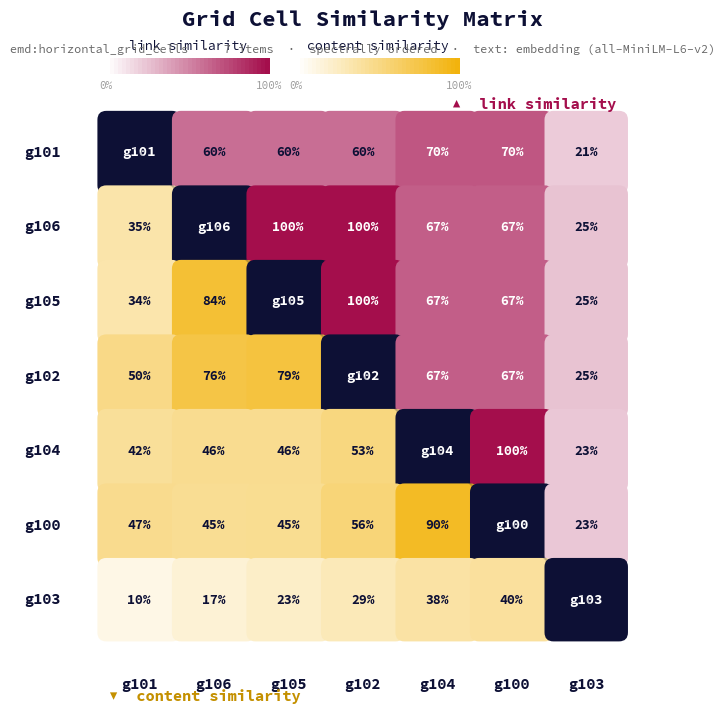

Saved → grid_similarity.png


In [9]:
def blend(hex_color, alpha, bg=(1., 1., 1.)):
    """Alpha-blend hex_color onto bg at opacity alpha → RGB tuple."""
    r, g, b = mcolors.to_rgb(hex_color)
    return (bg[0]*(1-alpha)+r*alpha, bg[1]*(1-alpha)+g*alpha, bg[2]*(1-alpha)+b*alpha)

CELL  = 1.0          # cell size in data units
PAD   = 0.06         # gap between cells
ROUND = 0.12         # corner radius

fig, ax = plt.subplots(figsize=(9, 9))
fig.patch.set_facecolor(WHITE)
ax.set_facecolor(WHITE)

from matplotlib.patches import FancyBboxPatch

for i in range(n):
    for j in range(n):
        x, y = j * CELL, (n - 1 - i) * CELL   # y flipped so row 0 is top

        if i == j:
            # Diagonal — soft navy square
            fc = mcolors.to_rgb(NAVY)
        elif i < j:
            # Upper triangle — link (red)
            fc = blend(RED, Lo[i, j])
        else:
            # Lower triangle — text (mustard)
            fc = blend(MUSTARD, To[i, j])

        patch = FancyBboxPatch(
            (x + PAD, y + PAD), CELL - 2*PAD, CELL - 2*PAD,
            boxstyle=f'round,pad={ROUND}',
            linewidth=0, facecolor=fc,
        )
        ax.add_patch(patch)

        # Value labels
        if i == j:
            ax.text(x + CELL/2, y + CELL/2, ordered_ids[i],
                    ha='center', va='center', fontsize=10, fontweight='bold',
                    color=WHITE, fontfamily=FONT)
        else:
            val = Lo[i, j] if i < j else To[i, j]
            if val > 0.08:
                lum = 0.299*fc[0] + 0.587*fc[1] + 0.114*fc[2]
                tc  = WHITE if lum < 0.55 else NAVY
                ax.text(x + CELL/2, y + CELL/2, f'{val:.0%}',
                        ha='center', va='center', fontsize=9.5, fontweight='bold',
                        color=tc, fontfamily=FONT)

# Axis labels on outer edges
for k, sid in enumerate(ordered_ids):
    # Bottom x-axis
    ax.text(k*CELL + CELL/2, -0.55, sid, ha='center', va='top',
            fontsize=11, color=NAVY, fontfamily=FONT, fontweight='bold')
    # Left y-axis (row 0 = top = index 0)
    ax.text(-0.55, (n-1-k)*CELL + CELL/2, sid, ha='right', va='center',
            fontsize=11, color=NAVY, fontfamily=FONT, fontweight='bold')

# Triangle annotations
ax.text(n*CELL - 0.1, n*CELL + 0.05,
        '▲  link similarity', ha='right', va='bottom',
        fontsize=11, color=RED, fontweight='bold', fontfamily=FONT)
ax.text(0.1, -0.7,
        '▼  content similarity', ha='left', va='top',
        fontsize=11, color='#c49000', fontweight='bold', fontfamily=FONT)

# Diagonal divider line
ax.plot([0, n*CELL], [n*CELL, 0], color=NAVY, lw=1.5, alpha=0.25, zorder=10)

# Gradient colour bars (manual, using a thin rect stack)
def draw_colorbar(ax, x0, y0, w, h, hex_color, label, ha='left'):
    steps = 40
    for s in range(steps):
        alpha = s / (steps - 1)
        rect = FancyBboxPatch((x0 + s*w/steps, y0), w/steps, h,
                               boxstyle='square,pad=0', linewidth=0,
                               facecolor=blend(hex_color, alpha))
        ax.add_patch(rect)
    ax.text(x0 + (w/2 if ha=='left' else 0), y0 + h + 0.07, label,
            ha='center', va='bottom', fontsize=9.5, color=NAVY, fontfamily=FONT)
    ax.text(x0,           y0 - 0.07, '0%',   ha='center', va='top', fontsize=8, color='#999', fontfamily=FONT)
    ax.text(x0 + w,       y0 - 0.07, '100%', ha='center', va='top', fontsize=8, color='#999', fontfamily=FONT)

draw_colorbar(ax, 0.05, n*CELL + 0.55, 2.2, 0.22, RED,     'link similarity')
draw_colorbar(ax, 2.6,  n*CELL + 0.55, 2.2, 0.22, MUSTARD, 'content similarity')

# Title
ax.text(n*CELL/2, n*CELL + 1.15, 'Grid Cell Similarity Matrix',
        ha='center', va='bottom', fontsize=16, fontweight='bold',
        color=NAVY, fontfamily=FONT)
ax.text(n*CELL/2, n*CELL + 0.82,
        f'{FOLDER_URL}  ·  {n} items  ·  spectrally ordered  ·  text: {text_method}',
        ha='center', va='bottom', fontsize=8.5, color='#666', fontfamily=FONT)

ax.set_xlim(-0.9, n*CELL + 0.1)
ax.set_ylim(-0.9, n*CELL + 1.4)
ax.set_aspect('equal')
ax.axis('off')

fig.savefig('grid_similarity.png', dpi=180, bbox_inches='tight', facecolor=WHITE)
plt.show()
print('Saved → grid_similarity.png')

---
## Interactive D3 adjacency matrix

In [ ]:
# Embed computed matrices into the HTML template
_data = json.dumps({
    'ids':    ordered_ids,
    'link':   Lo.tolist(),
    'text':   To.tolist(),
    'method': text_method,
    'folder': FOLDER_URL,
})

HTML_TEMPLATE = """
<!DOCTYPE html>
<html>
<head>
<meta charset="utf-8">
<link href="https://fonts.googleapis.com/css2?family=Source+Code+Pro:wght@400;600;700&display=swap" rel="stylesheet">
<script src="https://d3js.org/d3.v7.min.js"></script>
<style>
  * { box-sizing: border-box; margin: 0; padding: 0; }
  body { font-family: 'Source Code Pro', monospace; background: #ffffff;
         display: flex; flex-direction: column; align-items: center;
         padding: 24px 24px 40px; }
  #chart { position: relative; }
  .tip {
    position: fixed; background: #0d1035; color: #fff;
    padding: 10px 14px; border-radius: 8px; font-size: 12px;
    font-family: 'Source Code Pro', monospace; pointer-events: none;
    opacity: 0; transition: opacity .12s; line-height: 1.9;
    box-shadow: 0 6px 24px rgba(0,0,0,.25); max-width: 240px;
  }
  .tip .tip-link { color: #e8607e; font-weight: 600; }
  .tip .tip-text { color: #f5c842; font-weight: 600; }
  .tip .tip-head { font-weight: 700; font-size: 13px;
                   border-bottom: 1px solid rgba(255,255,255,.2);
                   padding-bottom: 5px; margin-bottom: 5px; }
</style>
</head>
<body>
<div id="chart"></div>
<div class="tip" id="tip"></div>

<script>
const D = __DATA__;
const { ids, link, text, method, folder } = D;

const n = ids.length;
// Smaller cells — fit comfortably in a notebook output
const cellSize = Math.min(60, Math.floor(Math.min(window.innerWidth * 0.72, 480) / n));
const gap      = Math.max(2, Math.round(cellSize * 0.055));
const inner    = cellSize - gap;
const radius   = Math.round(inner * 0.14);
const FONT     = "'Source Code Pro', monospace";

const TITLE_H = 54;   // title + subtitle
const XLBL_H  = Math.round(cellSize * 0.55); // horizontal x-axis label strip
const LEG_H   = 58;   // gradient legend bars
const margin  = { top: TITLE_H, right: 20,
                  bottom: XLBL_H + LEG_H + 24,
                  left: Math.round(cellSize * 0.88) };

const W = n * cellSize + margin.left + margin.right;
const H = n * cellSize + margin.top  + margin.bottom;

const RED     = '#a40e4C';
const MUSTARD = '#f2b30d';
const NAVY    = '#0d1035';
const WHITE   = '#ffffff';

function hexToRgb(h) {
  return [parseInt(h.slice(1,3),16)/255, parseInt(h.slice(3,5),16)/255, parseInt(h.slice(5,7),16)/255];
}
function blend(hex, a) {
  const [r,g,b] = hexToRgb(hex);
  return `rgb(${Math.round((1-a+r*a)*255)},${Math.round((1-a+g*a)*255)},${Math.round((1-a+b*a)*255)})`;
}

const svg = d3.select('#chart').append('svg').attr('width', W).attr('height', H);
const defs = svg.append('defs');

// Gradient defs for legend bars
[['leg-red', RED], ['leg-mustard', MUSTARD]].forEach(([id, col]) => {
  const gr = defs.append('linearGradient').attr('id', id).attr('x1','0%').attr('x2','100%');
  gr.append('stop').attr('offset','0%').attr('stop-color', WHITE);
  gr.append('stop').attr('offset','100%').attr('stop-color', col);
});

// Title (inside SVG, above matrix)
svg.append('text')
  .attr('x', W/2).attr('y', 24)
  .attr('text-anchor','middle').attr('font-family', FONT)
  .attr('font-size', 17).attr('font-weight', 700).attr('fill', NAVY)
  .text('Grid Cell Similarity Matrix');
svg.append('text')
  .attr('x', W/2).attr('y', 41)
  .attr('text-anchor','middle').attr('font-family', FONT)
  .attr('font-size', 9).attr('fill','#999')
  .text(folder + '  ·  ' + n + ' items  ·  spectrally ordered  ·  ' + method);

const g = svg.append('g').attr('transform', `translate(${margin.left},${margin.top})`);
const tip = d3.select('#tip');

// ── Cells ──────────────────────────────────────────────────────────────────
const cellData = [];
for (let i=0;i<n;i++) for (let j=0;j<n;j++) cellData.push({i,j});

g.selectAll('.cell').data(cellData).join('rect')
  .attr('class','cell')
  .attr('x',      d => d.j*cellSize + gap/2)
  .attr('y',      d => d.i*cellSize + gap/2)
  .attr('width',  inner).attr('height', inner).attr('rx', radius)
  .attr('fill', d => {
    if (d.i===d.j) return NAVY;
    return d.i < d.j ? blend(RED, link[d.i][d.j]) : blend(MUSTARD, text[d.i][d.j]);
  })
  .style('cursor', d => d.i===d.j ? 'default' : 'pointer')
  .on('mouseover', function(event, d) {
    if (d.i===d.j) return;
    const li=Math.min(d.i,d.j), lj=Math.max(d.i,d.j);
    tip.style('opacity',1).html(
      `<div class="tip-head">${ids[d.i]} ↔ ${ids[d.j]}</div>` +
      `<span class="tip-link">▲ Link</span>&nbsp; ${(link[li][lj]*100).toFixed(1)}%<br>` +
      `<span class="tip-text">▼ Content</span>&nbsp; ${(text[lj][li]*100).toFixed(1)}%`
    );
    d3.select(this).attr('stroke',NAVY).attr('stroke-width',2);
    g.selectAll('.cell').filter(e => e.i!==d.i && e.j!==d.j).attr('opacity',0.35);
  })
  .on('mousemove', ev => tip.style('left',(ev.clientX+14)+'px').style('top',(ev.clientY-10)+'px'))
  .on('mouseout', function() {
    tip.style('opacity',0);
    d3.select(this).attr('stroke','none');
    g.selectAll('.cell').attr('opacity',1);
  });

// ── Value labels inside cells ───────────────────────────────────────────────
g.selectAll('.val').data(cellData.filter(d=>d.i!==d.j)).join('text')
  .attr('class','val')
  .attr('x', d => d.j*cellSize + cellSize/2)
  .attr('y', d => d.i*cellSize + cellSize/2)
  .attr('dy','0.35em').attr('text-anchor','middle')
  .attr('font-family', FONT)
  .attr('font-size', Math.max(8, Math.round(cellSize*0.16)))
  .attr('font-weight',600).attr('pointer-events','none')
  .attr('fill', d => {
    const v = d.i<d.j ? link[d.i][d.j] : text[d.i][d.j];
    if (v<0.08) return 'none';
    const [r,gg,b] = hexToRgb(d.i<d.j ? RED : MUSTARD);
    return (0.299*(1-v+r*v) + 0.587*(1-v+gg*v) + 0.114*(1-v+b*v)) < 0.55 ? WHITE : NAVY;
  })
  .text(d => { const v=d.i<d.j?link[d.i][d.j]:text[d.i][d.j]; return v>=0.08?Math.round(v*100)+'%':''; });

// ── Diagonal labels ─────────────────────────────────────────────────────────
g.selectAll('.diag').data(ids).join('text')
  .attr('class','diag')
  .attr('x', (d,i) => i*cellSize+cellSize/2)
  .attr('y', (d,i) => i*cellSize+cellSize/2)
  .attr('dy','0.35em').attr('text-anchor','middle')
  .attr('font-family', FONT)
  .attr('font-size', Math.max(9, Math.round(cellSize*0.18)))
  .attr('font-weight',700).attr('fill',WHITE).attr('pointer-events','none')
  .text(d=>d);

// ── Axis labels (horizontal) ─────────────────────────────────────────────────
const lblFs = Math.max(10, Math.round(cellSize*0.17));

// X-axis — horizontal labels below matrix
g.selectAll('.xlabel').data(ids).join('text')
  .attr('class','xlabel')
  .attr('x', (d,i) => i*cellSize+cellSize/2)
  .attr('y', n*cellSize + Math.round(cellSize*0.26))
  .attr('text-anchor','middle').attr('dominant-baseline','hanging')
  .attr('font-family', FONT).attr('font-size', lblFs)
  .attr('font-weight',600).attr('fill', NAVY)
  .text(d=>d);

// Y-axis labels — left side
g.selectAll('.ylabel').data(ids).join('text')
  .attr('class','ylabel')
  .attr('x', -Math.round(cellSize*0.16))
  .attr('y', (d,i) => i*cellSize+cellSize/2)
  .attr('text-anchor','end').attr('dominant-baseline','middle')
  .attr('font-family', FONT).attr('font-size', lblFs)
  .attr('font-weight',600).attr('fill', NAVY)
  .text(d=>d);

// Diagonal divider line
g.append('line')
  .attr('x1',0).attr('y1',0).attr('x2',n*cellSize).attr('y2',n*cellSize)
  .attr('stroke',NAVY).attr('stroke-width',1.5)
  .attr('stroke-dasharray','5,4').attr('opacity',0.22);

// ── Legend — gradient bars at the bottom ──────────────────────────────────────
const legY   = n*cellSize + XLBL_H + 22;  // y-position inside g group
const barW   = Math.floor(n*cellSize * 0.43);
const barH   = 13;
const legFs  = Math.max(9, Math.round(cellSize * 0.16));

// Red bar — left side
g.append('text')
  .attr('x',0).attr('y', legY-8)
  .attr('text-anchor','start').attr('font-family', FONT)
  .attr('font-size', legFs).attr('font-weight',700).attr('fill', RED)
  .text('▲  link similarity');
g.append('rect')
  .attr('x',0).attr('y', legY)
  .attr('width', barW).attr('height', barH)
  .attr('rx',3).attr('fill','url(#leg-red)');
g.append('text').attr('x',0).attr('y', legY+barH+9)
  .attr('text-anchor','start').attr('font-size', legFs-1)
  .attr('fill','#bbb').attr('font-family', FONT).text('0%');
g.append('text').attr('x', barW).attr('y', legY+barH+9)
  .attr('text-anchor','end').attr('font-size', legFs-1)
  .attr('fill','#bbb').attr('font-family', FONT).text('100%');

// Mustard bar — right side
const mustX = n*cellSize - barW;
g.append('text')
  .attr('x', mustX).attr('y', legY-8)
  .attr('text-anchor','start').attr('font-family', FONT)
  .attr('font-size', legFs).attr('font-weight',700).attr('fill','#c49000')
  .text('▼  content similarity');
g.append('rect')
  .attr('x', mustX).attr('y', legY)
  .attr('width', barW).attr('height', barH)
  .attr('rx',3).attr('fill','url(#leg-mustard)');
g.append('text').attr('x', mustX).attr('y', legY+barH+9)
  .attr('text-anchor','start').attr('font-size', legFs-1)
  .attr('fill','#bbb').attr('font-family', FONT).text('0%');
g.append('text').attr('x', mustX+barW).attr('y', legY+barH+9)
  .attr('text-anchor','end').attr('font-size', legFs-1)
  .attr('fill','#bbb').attr('font-family', FONT).text('100%');

// Hover hint
g.append('text')
  .attr('x', n*cellSize/2).attr('y', legY+barH+28)
  .attr('text-anchor','middle').attr('font-size', 9)
  .attr('font-family', FONT).attr('fill','#ccc')
  .text('hover any cell for details');

</script>
</body></html>
"""

html_out = HTML_TEMPLATE.replace('__DATA__', _data)

with open('grid_similarity.html', 'w') as f:
    f.write(html_out)
print('Saved → grid_similarity.html')

display(HTML(html_out))